# Project: Image Classification and Regression
## MVA - CentraleSupelec
### Etienne ROUANET-LABE

In this project, I will familiarize with Keras environment for Tensorflow and will implement my first neural networks.

In a first part I will implement a neural network in order to classify those pictures, using a fully connected network, then a convolutional network.
In a second part I will try and determine the position of the vertices of a triangle.
In the third part, I will show how I designed a hourglass network in order to denoise those pictures.

## I - Generate the data

### a) Generate geometrix shapes

Here is the given code for the generation of shapes. The data is made of pictures of squares, disks, and triangles.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import utils as np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Conv2DTranspose, Concatenate, Input
from keras.layers.merge import concatenate
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 80

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

### b) Pictures generated
Here are examples of generated shapes using the given functions.

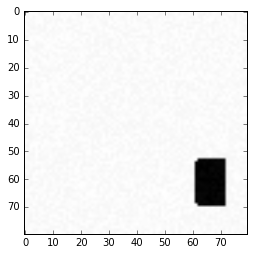

In [2]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

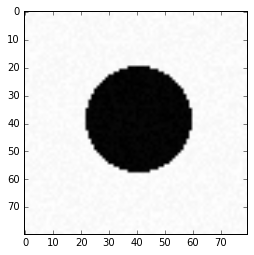

In [3]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

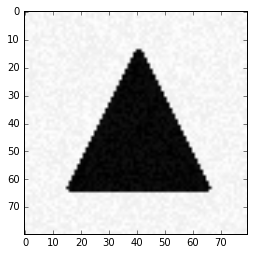

In [4]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### c) Generate the datasets

Here is how the data is generated for the classification and regression problems

In [5]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [6]:
import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## II - Neural Network for classification

In this first part, I design a neural network in order to determine if the given data is a picture of a triangle, disk, or rectangle.
I first try a fully connected neural network, then a convolutional neural network.

### a) Generate training and test sets

In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train=np_utils.to_categorical(Y_train)

[X_test, Y_test] = generate_dataset_classification(100, 20)
Y_test=np_utils.to_categorical(Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90


### b) Linear network

This first design for a network is just a linear network. Right after the input is the output, which is constituted of 3 neurons, each of those corresponding to a class. The loss function is the categorical crossentropy, which is classical for a multi-class classification problem.
It is easy to notice that such a network is just equivalent to a multi-class logistic regression with 3 classes. 

#### i. SGD optimizer
In a first attempt, the sgd optimizer is used.

In [8]:
#5linear,3softmax
model_simple_classification=Sequential([Dense(3,input_shape=(6400,)),Activation('softmax'),])
model_simple_classification.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
hist_simple_classification=model_simple_classification.fit(X_train,Y_train,epochs=250,batch_size=20,validation_data=(X_test, Y_test))

Train on 300 samples, validate on 100 samples
Epoch 1/250
300/300 [==============================] - 0s 396us/step - loss: 7.5530 - acc: 0.3733 - val_loss: 6.7110 - val_acc: 0.4900
Epoch 2/250
300/300 [==============================] - 0s 140us/step - loss: 6.1473 - acc: 0.5333 - val_loss: 6.3895 - val_acc: 0.3100
Epoch 3/250
300/300 [==============================] - 0s 143us/step - loss: 6.7897 - acc: 0.4333 - val_loss: 5.6806 - val_acc: 0.6300
Epoch 4/250
300/300 [==============================] - 0s 167us/step - loss: 5.1880 - acc: 0.6500 - val_loss: 5.6545 - val_acc: 0.6400
Epoch 5/250
300/300 [==============================] - 0s 157us/step - loss: 4.9432 - acc: 0.6633 - val_loss: 5.9798 - val_acc: 0.5200
Epoch 6/250
300/300 [==============================] - 0s 157us/step - loss: 5.4037 - acc: 0.5967 - val_loss: 5.6522 - val_acc: 0.6400
Epoch 7/250
300/300 [==============================] - 0s 167us/step - loss: 4.9021 - acc: 0.6967 - val_loss: 5.6472 - val_acc: 0.6500
Epoch 8/2

It is noticeable that with the default parameters, the network doesn't fit and stays at 0.65 validation accuracy. This is probably because the optimizer stays stuck in a local minimum or a saddle point.

#### ii. Adam optimizer
Now let's try the Adam optimizer.

In [9]:
model_simple_classification2=Sequential([Dense(3,input_shape=(6400,)),Activation('softmax'),])
model_simple_classification2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist_simple_classification2=model_simple_classification2.fit(X_train,Y_train,epochs=250,batch_size=32,validation_data=(X_test, Y_test))

Train on 300 samples, validate on 100 samples
Epoch 1/250
300/300 [==============================] - 0s 460us/step - loss: 2.8982 - acc: 0.3900 - val_loss: 1.0854 - val_acc: 0.5100
Epoch 2/250
300/300 [==============================] - 0s 127us/step - loss: 0.9887 - acc: 0.5900 - val_loss: 0.7677 - val_acc: 0.6100
Epoch 3/250
300/300 [==============================] - 0s 130us/step - loss: 0.5646 - acc: 0.7767 - val_loss: 0.4865 - val_acc: 0.8800
Epoch 4/250
300/300 [==============================] - 0s 133us/step - loss: 0.3916 - acc: 0.8933 - val_loss: 0.4586 - val_acc: 0.7200
Epoch 5/250
300/300 [==============================] - 0s 130us/step - loss: 0.3499 - acc: 0.8533 - val_loss: 0.3927 - val_acc: 0.7500
Epoch 6/250
300/300 [==============================] - 0s 130us/step - loss: 0.2452 - acc: 0.9133 - val_loss: 0.1786 - val_acc: 0.9800
Epoch 7/250
300/300 [==============================] - 0s 130us/step - loss: 0.1751 - acc: 0.9567 - val_loss: 0.2021 - val_acc: 0.8700
Epoch 8/2

The Adam optimizer fits and the validation accuracy is perfect. This shows that maybe the SGD optimizer is a bit rudimental and doesn't perform well in some cases, even the simplest ones.

#### iii. Visualisation of the weights
Now let's display the weights of each pixel of a picture for each class.

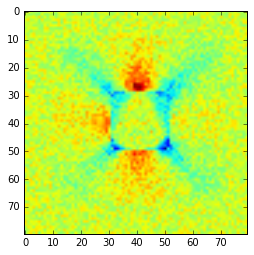

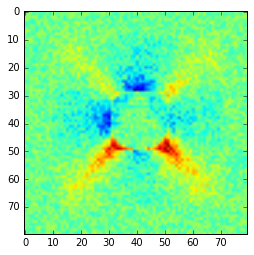

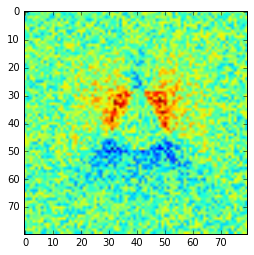

In [10]:
A=model_simple_classification2.get_weights()[0]
Weights_simple_classification2=[A[:,0],A[:,1],A[:,2]]
for i in range(3):
    plt.imshow(Weights_simple_classification2[i].reshape(80,80))
    plt.show()

We can notice that the shapes of the visualization of the weights of the network look like the geometric shapes they are designed to predict.

### c) Classification of shapes with random positionning


Now the goal is to :

-try and see if the previous linear model can determine the class of a randomly positionned shape

-implement a convolutional neural network to see if it would perform better

#### i. Generate the random data

In [11]:
[X_train2, Y_train2] = generate_dataset_classification(300, 20,True)
Y_train2=np_utils.to_categorical(Y_train2)

[X_test2, Y_test2] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


#### ii. Fit a fully connected network
Let's fit a fully connected network in order to check its performance.
I tried some simple network architectures. As the linear classifier performed poorly, I chose to display below the fitting of a  network made of 4 hidden layers and regularized with dropout.

The network is trained on 300 samples.

In [19]:
model_simple_classification3=Sequential([Dense(50,input_shape=(6400,)),Dropout(0.2),Activation('relu'),Dense(20),Dropout(0.2),Activation('relu'),Dense(10),Dropout(0.2),Activation('relu'),Dense(7),Activation('relu'),Dense(3),Activation('softmax')])
model_simple_classification3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
his_simple_classification3=model_simple_classification3.fit(X_train2,Y_train2,epochs=250,batch_size=32,validation_data=(X_test2,Y_test2))

Train on 300 samples, validate on 300 samples
Epoch 1/250
300/300 [==============================] - 1s 2ms/step - loss: 1.4387 - acc: 0.3267 - val_loss: 1.1265 - val_acc: 0.3833
Epoch 2/250
300/300 [==============================] - 0s 620us/step - loss: 1.3361 - acc: 0.3633 - val_loss: 1.1136 - val_acc: 0.3733
Epoch 3/250
300/300 [==============================] - 0s 530us/step - loss: 1.1983 - acc: 0.3333 - val_loss: 1.0881 - val_acc: 0.3833
Epoch 4/250
300/300 [==============================] - 0s 496us/step - loss: 1.0887 - acc: 0.3733 - val_loss: 1.0966 - val_acc: 0.3367
Epoch 5/250
300/300 [==============================] - 0s 520us/step - loss: 1.1346 - acc: 0.3100 - val_loss: 1.0892 - val_acc: 0.3800
Epoch 6/250
300/300 [==============================] - 0s 506us/step - loss: 1.1243 - acc: 0.3667 - val_loss: 1.0639 - val_acc: 0.4333
Epoch 7/250
300/300 [==============================] - 0s 493us/step - loss: 1.0704 - acc: 0.4200 - val_loss: 1.0780 - val_acc: 0.4500
Epoch 8/250

We seem to reach a peak accuracy of around 0.6, which is not satisfying for this simple classification problem.

Let's still notice that I only used 300 samples for the fitting of the model.

#### iii. Fit a convolutional neural network

Let's try a convolutional neural network architecture to fit the data.

In a first architecture, a single convolutional layer is used, followed by fully connected layers for classification.

The regularization used is a Max Pooling layer.

The training is done on 300 samples.

In [13]:
X_train2D1=X_train2.reshape(-1,80,80,1)
X_test2D=X_test2.reshape(-1,80,80,1)

In [14]:
model_conv_classification1=Sequential()
model_conv_classification1.add(Conv2D(16, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(80,80,1)))
model_conv_classification1.add(MaxPooling2D(pool_size=(5,5)))
model_conv_classification1.add(Flatten())
model_conv_classification1.add(Dense(50,activation='relu'))
model_conv_classification1.add(Dense(3,activation='softmax'))
model_conv_classification1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist_conv_classification1=model_conv_classification1.fit(X_train2D1,Y_train2,epochs=70,batch_size=32,validation_data=(X_test2D,Y_test2))

Train on 300 samples, validate on 300 samples
Epoch 1/70
300/300 [==============================] - 1s 5ms/step - loss: 1.1006 - acc: 0.3967 - val_loss: 1.0085 - val_acc: 0.5433
Epoch 2/70
300/300 [==============================] - 1s 4ms/step - loss: 0.9236 - acc: 0.6933 - val_loss: 0.9158 - val_acc: 0.6300
Epoch 3/70
300/300 [==============================] - 1s 4ms/step - loss: 0.7863 - acc: 0.7367 - val_loss: 0.7979 - val_acc: 0.6800
Epoch 4/70
300/300 [==============================] - 1s 4ms/step - loss: 0.6645 - acc: 0.7767 - val_loss: 0.7781 - val_acc: 0.6500
Epoch 5/70
300/300 [==============================] - 1s 4ms/step - loss: 0.6068 - acc: 0.7800 - val_loss: 0.7856 - val_acc: 0.6367
Epoch 6/70
300/300 [==============================] - 1s 4ms/step - loss: 0.5566 - acc: 0.7900 - val_loss: 0.7245 - val_acc: 0.7000
Epoch 7/70
300/300 [==============================] - 1s 4ms/step - loss: 0.4968 - acc: 0.8400 - val_loss: 0.6702 - val_acc: 0.7333
Epoch 8/70
300/300 [==========

The peak accuracy for this network fitted with 300 samples is about 0.78.

Now let's add dropout to the previous network and see if anything changes.

In [20]:
model_conv_classification2=Sequential()
model_conv_classification2.add(Conv2D(16, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(80,80,1)))
model_conv_classification2.add(MaxPooling2D(pool_size=(10,10)))
model_conv_classification2.add(Flatten())
model_conv_classification2.add(Dense(20,activation='relu'))
model_conv_classification2.add(Dropout(0.4))
model_conv_classification2.add(Dense(3,activation='softmax'))
model_conv_classification2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist_conv_classification2_300=model_conv_classification2.fit(X_train2D1,Y_train2,epochs=70,batch_size=32,validation_data=(X_test2D,Y_test2))

Train on 300 samples, validate on 300 samples
Epoch 1/70
300/300 [==============================] - 1s 5ms/step - loss: 1.1109 - acc: 0.3567 - val_loss: 1.0817 - val_acc: 0.3833
Epoch 2/70
300/300 [==============================] - 1s 4ms/step - loss: 1.0752 - acc: 0.4133 - val_loss: 1.0707 - val_acc: 0.3667
Epoch 3/70
300/300 [==============================] - 1s 4ms/step - loss: 1.0558 - acc: 0.4100 - val_loss: 1.0558 - val_acc: 0.4133
Epoch 4/70
300/300 [==============================] - 1s 4ms/step - loss: 1.0131 - acc: 0.4700 - val_loss: 1.0331 - val_acc: 0.5400
Epoch 5/70
300/300 [==============================] - 1s 4ms/step - loss: 1.0052 - acc: 0.5367 - val_loss: 1.0140 - val_acc: 0.4800
Epoch 6/70
300/300 [==============================] - 1s 4ms/step - loss: 0.9762 - acc: 0.5567 - val_loss: 0.9880 - val_acc: 0.5433
Epoch 7/70
300/300 [==============================] - 1s 4ms/step - loss: 0.9559 - acc: 0.5333 - val_loss: 0.9827 - val_acc: 0.6100
Epoch 8/70
300/300 [==========

We can notice that the accuracy went from 0.78 to 0.80. It doesn't change much though.

#### iv. Deep convolutional network

We are still using 300 samples. Let's see if a deeper CNN woudl allow to fit better, with that fixed 300 samples.

Let's add a convolution layer and some fully connected layers.

In [26]:
model_conv_classification3=Sequential()
model_conv_classification3.add(Conv2D(16, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(80,80,1)))
model_conv_classification3.add(Dropout(0.2))
model_conv_classification3.add(MaxPooling2D(pool_size=(7,7)))
model_conv_classification3.add(Conv2D(30, kernel_size=(3,3), activation='relu'))
model_conv_classification3.add(Dropout(0.2))
model_conv_classification3.add(MaxPooling2D(pool_size=(3,3)))
model_conv_classification3.add(Flatten())
model_conv_classification3.add(Dense(50,activation='relu'))
model_conv_classification3.add(Dropout(0.3))
model_conv_classification3.add(Dense(20,activation='relu'))
model_conv_classification3.add(Dropout(0.5))
model_conv_classification3.add(Dense(3,activation='softmax'))
model_conv_classification3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist_conv_classification3_300=model_conv_classification3.fit(X_train2D1,Y_train2,epochs=70,batch_size=32,validation_data=(X_test2D,Y_test2))

Train on 300 samples, validate on 300 samples
Epoch 1/70
300/300 [==============================] - 2s 7ms/step - loss: 1.1188 - acc: 0.3633 - val_loss: 1.1059 - val_acc: 0.3167
Epoch 2/70
300/300 [==============================] - 2s 5ms/step - loss: 1.1254 - acc: 0.3133 - val_loss: 1.0967 - val_acc: 0.3667
Epoch 3/70
300/300 [==============================] - 2s 5ms/step - loss: 1.0953 - acc: 0.3567 - val_loss: 1.0939 - val_acc: 0.4133
Epoch 4/70
300/300 [==============================] - 2s 5ms/step - loss: 1.0930 - acc: 0.3500 - val_loss: 1.0919 - val_acc: 0.4233
Epoch 5/70
300/300 [==============================] - 2s 5ms/step - loss: 1.0789 - acc: 0.4333 - val_loss: 1.0879 - val_acc: 0.4200
Epoch 6/70
300/300 [==============================] - 2s 5ms/step - loss: 1.0779 - acc: 0.4167 - val_loss: 1.0822 - val_acc: 0.4433
Epoch 7/70
300/300 [==============================] - 2s 5ms/step - loss: 1.0651 - acc: 0.4267 - val_loss: 1.0746 - val_acc: 0.4267
Epoch 8/70
300/300 [==========

For few data samples, a deeper CNN structure seems to perform better, as the accuracy went from 0.80 to 0.89.

#### v. Same networks with more data

Let's continue fitting the two previous networks with a training set of 1000 samples, and check the improvement of our accuracy.

In [23]:
[X_train3, Y_train3] = generate_dataset_classification(1000, 20,True)
Y_train3=np_utils.to_categorical(Y_train3)
X_train2D2=X_train3.reshape(-1,80,80,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


The first one-layer CNN is re-trained and testes on the new test set.

In [24]:
hist_conv_classification2_1000=model_conv_classification2.fit(X_train2D2,Y_train3,epochs=70,batch_size=32,validation_data=(X_test2D,Y_test2))

Train on 1000 samples, validate on 300 samples
Epoch 1/70
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5596 - acc: 0.8010 - val_loss: 0.5297 - val_acc: 0.8133
Epoch 2/70
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5601 - acc: 0.7880 - val_loss: 0.4600 - val_acc: 0.8233
Epoch 3/70
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5183 - acc: 0.8070 - val_loss: 0.4782 - val_acc: 0.8233
Epoch 4/70
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4866 - acc: 0.8130 - val_loss: 0.4211 - val_acc: 0.8600
Epoch 5/70
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4730 - acc: 0.8220 - val_loss: 0.4390 - val_acc: 0.8533
Epoch 6/70
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4535 - acc: 0.8220 - val_loss: 0.3779 - val_acc: 0.8767
Epoch 7/70
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4305 - acc: 0.8260 - val_loss: 0.3709 - val_acc: 0.8767
Epoch 8/70
1000

We notice that the augmentation of the size of the training set from 300 to 1000 samples increased the accuracy of the first network from 0.78 to 0.93.

In [28]:
hist_conv_classification3_1000=model_conv_classification3.fit(X_train2D2,Y_train3,epochs=25,batch_size=32,validation_data=(X_test2D,Y_test2))

Train on 1000 samples, validate on 300 samples
Epoch 1/25
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1421 - acc: 0.9510 - val_loss: 0.1441 - val_acc: 0.9567
Epoch 2/25
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1434 - acc: 0.9500 - val_loss: 0.1361 - val_acc: 0.9500
Epoch 3/25
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1399 - acc: 0.9540 - val_loss: 0.1279 - val_acc: 0.9533
Epoch 4/25
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1533 - acc: 0.9450 - val_loss: 0.1429 - val_acc: 0.9600
Epoch 5/25
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1207 - acc: 0.9570 - val_loss: 0.1170 - val_acc: 0.9600
Epoch 6/25
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1107 - acc: 0.9660 - val_loss: 0.1694 - val_acc: 0.9367
Epoch 7/25
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1309 - acc: 0.9580 - val_loss: 0.1274 - val_acc: 0.9600
Epoch 8/25
1000

For 1000 samples training set we get the satisfying accuracy of 0.96 for the deep CNN.

#### vi. Evaluation of the performance

Here is the display of the performance of the 2 CNN I tried for a trainign dataset of 1000 samples.

In [29]:
model_conv_classification2.evaluate(X_test2D,Y_test2)

300/300 [==============================] - 0s 1ms/step


[0.1882333271453778, 0.9266666666666666]

In [30]:
model_conv_classification3.evaluate(X_test2D,Y_test2)

300/300 [==============================] - 0s 1ms/step


[0.11056900600592295, 0.9633333333333334]

## III - Neural Network for regression

The methods I tried to implement here imply the use of a heat-map which I heard is not allowed to be used here. I didn't find any convincing method to return the position of the vertices.

## IV - Hourglass network for image denoising

A recently used denoising technique is the use of neural networks. Hourglass neural networks are an architecture of neural networks that allows to have an image as the output. 

Therefore, a dataset of noised/denoised pair of images should allow to train a neural network in order to denoise similar images.

### a) Generation of the dataset

Let's change the original training and test datasets in order to have a noised image as the input and the corresponding denoised image as the output.

In [32]:
def generate_a_rectangle_2(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)]


def generate_a_disk_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)]

def generate_a_triangle_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)]
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        noise=np.random.uniform(50)
        if category == 0:
            [X[i],Y[i]] = generate_a_rectangle_2(noise, free_location)
        elif category == 1: 
            [X[i],Y[i]] = generate_a_disk_2(noise, free_location)
        else:
            [X[i],Y[i]] = generate_a_triangle_2(noise, free_location)[0]
        X[i] = (X[i] + noise) / (255 + 2 * noise)
        Y[i] = Y[i] / 255
    return [X, Y]

def generate_test_set_denoising(n, free_location=False):
    [X_test, Y_test] = generate_dataset_denoising(n, free_location)
    return [X_test, Y_test]

Here is the display of a such a pair of noised/denoised images.

Creating data:
0


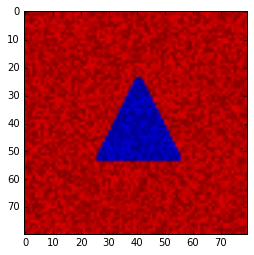

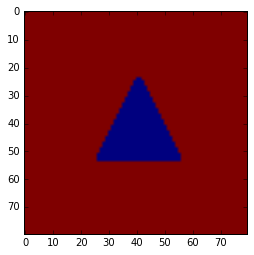

In [33]:
A=generate_dataset_denoising(1)
plt.imshow(A[0].reshape(80,80))
plt.show()
plt.imshow(A[1].reshape(80,80))

### b) Denoising with fixed positions

In a first try, we will generate a dataset with free_location=False (fixed positions for the images) in order to see how a hourglass network is designed and check fi the results are satisfying or not.

#### i. Generation of the dataset

In [34]:
[X_train_dn,Y_train_dn]=generate_dataset_denoising(300)
X_train_dn=X_train_dn.reshape(-1,80,80,1)
Y_train_dn=Y_train_dn.reshape(-1,80,80,1)
[X_test_dn,Y_test_dn]=generate_test_set_denoising(10)
X_test_dn=X_test_dn.reshape(-1,80,80,1)
Y_test_dn=Y_test_dn.reshape(-1,80,80,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0


#### ii. Hourglass network without merged layers
Below is a first structure of hourglass network, using Sequential.
Here the corresponding layers aren't merged, so that the efficiency of the merging technique can be notieable.

In [35]:
model_hourglass=Sequential()
model_hourglass.add(Conv2D(16, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(80,80,1)))
model_hourglass.add(MaxPooling2D(pool_size=(3,3)))
model_hourglass.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_hourglass.add(MaxPooling2D(pool_size=(3,3)))
model_hourglass.add(Conv2DTranspose(32,(3,3),strides=(3,3)))
#concatenate
model_hourglass.add(Conv2D(32, kernel_size=(6,6), activation='relu'))
model_hourglass.add(Conv2DTranspose(16,(2,2),strides=(4,4)))
#concatenate
model_hourglass.add(Conv2D(16, kernel_size=(2,2), activation='relu'))
model_hourglass.add(Conv2DTranspose(16,(7,7),strides=(1,1)))
model_hourglass.add(Conv2D(1, kernel_size=(2,2), activation='sigmoid'))
model_hourglass.compile(optimizer='adam',loss='binary_crossentropy')
hist_hourglass=model_hourglass.fit(X_train_dn,Y_train_dn,epochs=70,batch_size=32,validation_data=(X_test_dn,Y_test_dn))

Train on 300 samples, validate on 10 samples
Epoch 1/70
300/300 [==============================] - 12s 39ms/step - loss: 0.6034 - val_loss: 0.5844
Epoch 2/70
300/300 [==============================] - 10s 34ms/step - loss: 0.4692 - val_loss: 0.4458
Epoch 3/70
300/300 [==============================] - 11s 35ms/step - loss: 0.3636 - val_loss: 0.3397
Epoch 4/70
300/300 [==============================] - 14s 45ms/step - loss: 0.2666 - val_loss: 0.2840
Epoch 5/70
300/300 [==============================] - 12s 42ms/step - loss: 0.2340 - val_loss: 0.2844
Epoch 6/70
300/300 [==============================] - 12s 38ms/step - loss: 0.2256 - val_loss: 0.2590
Epoch 7/70
300/300 [==============================] - 12s 39ms/step - loss: 0.2121 - val_loss: 0.2447
Epoch 8/70
300/300 [==============================] - 12s 39ms/step - loss: 0.2032 - val_loss: 0.2346
Epoch 9/70
300/300 [==============================] - 11s 38ms/step - loss: 0.1941 - val_loss: 0.2180
Epoch 10/70
300/300 [================

The final validation loss for such a model is 0.0391. Though the result is not very satisfying, it is noticeable that the validation accuracy was still decresing, so maybe more epochs would have given a more satisfying result. However, the epochs of an hourglass network take quite some time on my computer, that's why I only stopped at 70 epochs.

#### iii. Hourglass network with merged layers
Below is approimately the same hourglass structure, but I added the merging of the corresponding U-layers to keep in memory the information on the shapes.

In [36]:
inputs=Input((80,80,1))
c1=Conv2D(16, kernel_size=(3,3),activation='relu')(inputs)
print(np.shape(c1))
c2=MaxPooling2D(pool_size=(3,3))(c1)
c3=Conv2D(32, kernel_size=(3,3), activation='relu')(c2)
c4=MaxPooling2D(pool_size=(3,3))(c3)
c5=Conv2DTranspose(32,(5,5),strides=(3,3))(c4)
c6=concatenate([c5,c2])
print(np.shape(c6))
c7=Conv2D(16, kernel_size=(2,2), activation='relu')(c6)
print(np.shape(c7))
c8=Conv2DTranspose(16,(6,6),strides=(3,3))(c7)
print(np.shape(c8))
c9=concatenate([c8,c1])
c10=Conv2D(16, kernel_size=(2,2), activation='relu')(c9)
c11=Conv2DTranspose(16,(5,5),strides=(1,1))(c10)
c12=Conv2D(1, kernel_size=(2,2), activation='sigmoid')(c11)
model_hourglass_2=Model(inputs=[inputs],outputs=[c12])
model_hourglass_2.compile(optimizer='adam',loss='binary_crossentropy')
hist_hourglass_2=model_hourglass_2.fit(X_train_dn,Y_train_dn,epochs=70,batch_size=32,validation_data=(X_test_dn,Y_test_dn))

(?, 78, 78, 16)
(?, 26, 26, 48)
(?, 25, 25, 16)
(?, ?, ?, 16)
Train on 300 samples, validate on 10 samples
Epoch 1/70
300/300 [==============================] - 10s 32ms/step - loss: 0.6211 - val_loss: 0.4922
Epoch 2/70
300/300 [==============================] - 10s 33ms/step - loss: 0.3573 - val_loss: 0.2548
Epoch 3/70
300/300 [==============================] - 10s 34ms/step - loss: 0.1236 - val_loss: 0.0339
Epoch 4/70
300/300 [==============================] - 9s 32ms/step - loss: 0.0281 - val_loss: 0.0260
Epoch 5/70
300/300 [==============================] - 9s 31ms/step - loss: 0.0247 - val_loss: 0.0165
Epoch 6/70
300/300 [==============================] - 9s 31ms/step - loss: 0.0165 - val_loss: 0.0146
Epoch 7/70
300/300 [==============================] - 9s 31ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 8/70
300/300 [==============================] - 9s 31ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 9/70
300/300 [==============================] - 9s 30ms/step - loss: 0.0092 

For this new hourglass network, the final validation loss is 2.7e-04, which is significantly beter than the previous structure.

#### iv. Display of the results

Creating data:
0
noised image


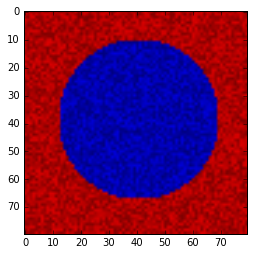

denoised image


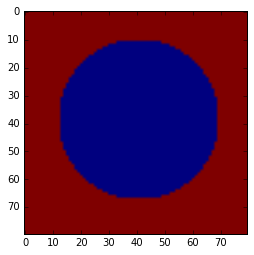

non-merged layers network result


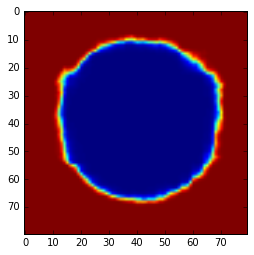

merged layers network result


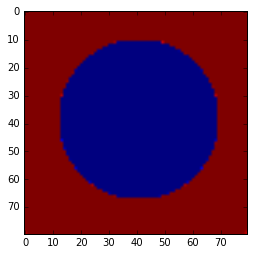

In [38]:
B=generate_test_set_denoising(2)
plt.imshow(B[0][1].reshape(80,80))
print('noised image')
plt.show()
plt.imshow(B[1][1].reshape(80,80))
print('denoised image')
plt.show()
print('non-merged layers network result')
C=model_hourglass.predict(B[0][1].reshape(-1,80,80,1))
C=C.reshape(80,80)
plt.imshow(C)
plt.show()
print('merged layers network result')
D=model_hourglass_2.predict(B[0][1].reshape(-1,80,80,1))
D=D.reshape(80,80)
plt.imshow(D)

### b) Dataset with random positions

Now, let's try the efficiency of the 2d model for a dataset in which the positions of the shapes are random.

#### i. Generation of the dataset

In [41]:
[X_train_dn1,Y_train_dn1]=generate_dataset_denoising(300,True)
X_train_dn1=X_train_dn1.reshape(-1,80,80,1)
Y_train_dn1=Y_train_dn1.reshape(-1,80,80,1)
[X_test_dn1,Y_test_dn1]=generate_test_set_denoising(10,True)
X_test_dn1=X_test_dn1.reshape(-1,80,80,1)
Y_test_dn1=Y_test_dn1.reshape(-1,80,80,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0


#### ii. Fitting hourglass network 1

In [46]:
hist_hourglass_1=model_hourglass.fit(X_train_dn1,Y_train_dn1,epochs=70,batch_size=32,validation_data=(X_test_dn1,Y_test_dn1))

Train on 300 samples, validate on 10 samples
Epoch 1/70
300/300 [==============================] - 11s 35ms/step - loss: 0.2519 - val_loss: 0.2065
Epoch 2/70
300/300 [==============================] - 11s 37ms/step - loss: 0.1493 - val_loss: 0.1350
Epoch 3/70
300/300 [==============================] - 11s 37ms/step - loss: 0.1240 - val_loss: 0.1227
Epoch 4/70
300/300 [==============================] - 12s 39ms/step - loss: 0.1132 - val_loss: 0.1146
Epoch 5/70
300/300 [==============================] - 12s 39ms/step - loss: 0.1091 - val_loss: 0.1085
Epoch 6/70
300/300 [==============================] - 11s 35ms/step - loss: 0.1045 - val_loss: 0.1061
Epoch 7/70
300/300 [==============================] - 12s 38ms/step - loss: 0.1015 - val_loss: 0.1011
Epoch 8/70
300/300 [==============================] - 11s 37ms/step - loss: 0.0995 - val_loss: 0.1000
Epoch 9/70
300/300 [==============================] - 11s 35ms/step - loss: 0.0977 - val_loss: 0.1003
Epoch 10/70
300/300 [================

Final acuracy of around 0.9
#### iii. Fitting hourglass network 2

In [42]:
hist_hourglass_2_1=model_hourglass_2.fit(X_train_dn1,Y_train_dn1,epochs=70,batch_size=32,validation_data=(X_test_dn1,Y_test_dn1))

Train on 300 samples, validate on 10 samples
Epoch 1/70
300/300 [==============================] - 9s 29ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/70
300/300 [==============================] - 8s 27ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/70
300/300 [==============================] - 8s 28ms/step - loss: 0.0011 - val_loss: 8.8981e-04
Epoch 4/70
300/300 [==============================] - 8s 28ms/step - loss: 7.5007e-04 - val_loss: 5.8026e-04
Epoch 5/70
300/300 [==============================] - 8s 27ms/step - loss: 5.0834e-04 - val_loss: 5.2686e-04
Epoch 6/70
300/300 [==============================] - 8s 28ms/step - loss: 4.2628e-04 - val_loss: 4.4669e-04
Epoch 7/70
300/300 [==============================] - 8s 28ms/step - loss: 3.8865e-04 - val_loss: 4.2375e-04
Epoch 8/70
300/300 [==============================] - 8s 27ms/step - loss: 3.6264e-04 - val_loss: 4.1891e-04
Epoch 9/70
300/300 [==============================] - 8s 28ms/step - loss: 3.4195e-04 - val_loss: 3.719

#### iv. Display of the results

Creating data:
0
noised image


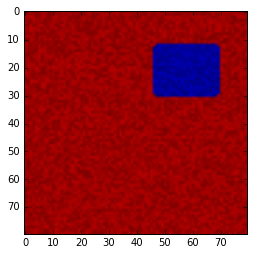

denoised image


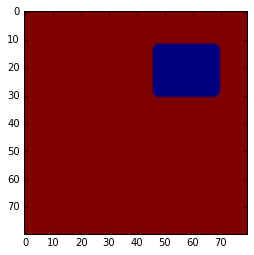

non-merged layers network result


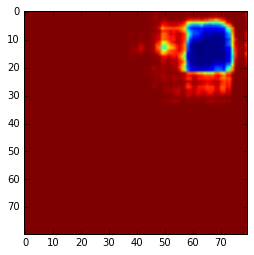

merged layers network result


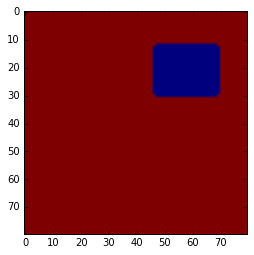

noised image


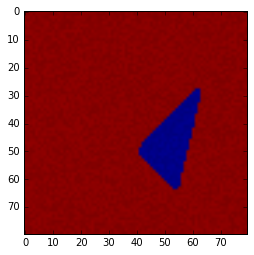

denoised image


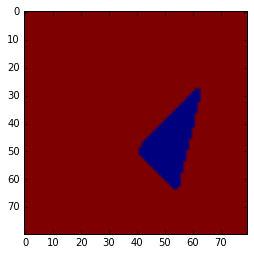

non-merged layers network result


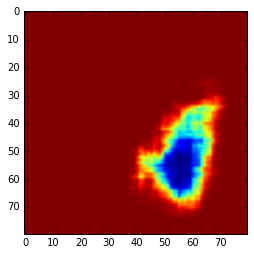

merged layers network result


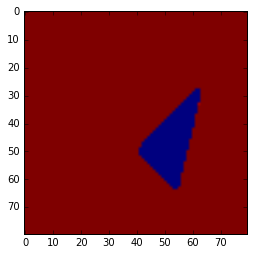

In [48]:
B1=generate_test_set_denoising(2,True)
plt.imshow(B1[0][1].reshape(80,80))
print('noised image')
plt.show()
plt.imshow(B1[1][1].reshape(80,80))
print('denoised image')
plt.show()
print('non-merged layers network result')
C1=model_hourglass.predict(B1[0][1].reshape(-1,80,80,1))
C1=C1.reshape(80,80)
plt.imshow(C1)
plt.show()
print('merged layers network result')
D1=model_hourglass_2.predict(B1[0][1].reshape(-1,80,80,1))
D1=D1.reshape(80,80)
plt.imshow(D1)
plt.show()
plt.imshow(B1[0][0].reshape(80,80))
print('noised image')
plt.show()
plt.imshow(B1[1][0].reshape(80,80))
print('denoised image')
plt.show()
print('non-merged layers network result')
C1=model_hourglass.predict(B1[0][0].reshape(-1,80,80,1))
C1=C1.reshape(80,80)
plt.imshow(C1)
plt.show()
print('merged layers network result')
D1=model_hourglass_2.predict(B1[0][0].reshape(-1,80,80,1))
D1=D1.reshape(80,80)
plt.imshow(D1)

The difference of performance is noticeable: the merging of layers in a U-network is absolutely necessary in order to get a coherent result.

However, the 2d hourglass network gives perfect results.